# Part1 - GRADCAM

### Import Libraries and Modules

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
import keras.backend as K
from skimage import io
from google.colab.patches import cv2_imshow

### Mount Drive

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Load an image and perform preprocessing


In [0]:
# Load VGG-16 Model trained on ImageNet Dataset
model = VGG16(weights="imagenet")

# Import an image from drive
rdj_input = io.imread("/content/gdrive/My Drive/Colab Notebooks/RDJ.JPG")

# VGG-16 model expects input image of size 224x244 so resizing the image  
rdj = cv2.resize(rdj_input, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

# Convert the image to array
x = image.img_to_array(rdj)

# Expand dimension of the array since Keras expects the model with 4-dimension (1st one for the batch size)
x = np.expand_dims(x, axis=0)

# Use preprocess function to normalize the image
x = preprocess_input(x)

### Model Prediction for the image 


In [0]:
preds = model.predict(x)

### Get prediction value for every single class

In [0]:
# Dictionary to store prediction value corresponding to each class
index={}

# For 1000 classes of imagenet
for i in range(len(preds[0])):
  class_pred_value = (preds[0][i])     # Prediction for class
  index[i] = class_pred_value          # Storing Class number and its corresponding prediction value in a dictionary
#   print(i, ": ", class_pred_value)     # Printing class number and its prediction value

### Top-5 Predictions

In [23]:
# List to store class output
outs = []

# Sorting based on prediction value
sorted_pred = sorted(index.items(), key = lambda kv:(kv[1], kv[0]))

for i in range(1,6):
  print(sorted_pred[-i])
  class_idx = sorted_pred[-i][0]             # Class number in imagenet dataset
  class_output = model.output[:, class_idx]  # Output of the VGG model
  outs.append(class_output)
#   print(class_idx)


(837, 0.33942142)
(836, 0.2550906)
(785, 0.04091668)
(740, 0.027877552)
(457, 0.019499576)


Top 5 Predicted Classes are:
1. Sunglasses, dark glasses, shades - 837
2. Sunglasses - 836
3. Seat-belt - 785
4. Power-drill - 740
5. Bow-tie - 457

[Link for 1000 classes labels](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

### Convolution Layers
![alt text](Data/vgg-net.jpg)

According to VGG Network Architecture, last second and last third layer has 512 kernels

In [0]:
# Last 2nd and 3rd convolution layer for activation
last_second_conv_layer = model.get_layer("block5_conv2")
last_third_conv_layer = model.get_layer("block5_conv1")

# Kernel in last 2nd and 3rd layer
kernels_last2 = 512
kernels_last3 = 512

### GradCam function

In [0]:
def gradOut(input_img, class_output, conv_layer, channel_number):
  '''
  Function to output heatmap of activation and an image showing where exactly the layer is looking in an image
  Input: Image, 
         prediction for particular class, 
         layer for which output is generated,
         total number of kernels in that layer
  Output: Heatmap,
          Image superimposed with heatmap (area where network is focusing in above mentioned layer)
  '''
  # Compute the gradient of the class output value with respect to the feature map
  grads = K.gradients(class_output, conv_layer.output)[0]
  
  # Pool the gradients over all the axies leaving out the channel dimension
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
  # Weigh the output feature map with the computed gradient values (Take global average of an image)
  iterate = K.function([model.input], [pooled_grads, conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  
  # Multiply each channel with its average value
  for i in range(channel_number):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  # Combine all channels to get one single channel
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  
  # Set all pixel values between 0 and maximum pixel value 
  heatmap = np.maximum(heatmap, 0)
  
  # Normalize the values between 0 and 1
  heatmap /= np.max(heatmap)
  
  # Resize heatmap to image size
  heatmap = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))
  
  # Convert it into 8bit image
  heatmap = np.uint8(255 * heatmap)
  
  # Apply colormap on heatmap
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  # Superimpose heatmap with input image
  superimposed_img = cv2.addWeighted(input_img, 0.6, heatmap, 0.4, 0)
  
  return superimposed_img, heatmap

### GradCam output for penultimate layer

Output of penultimate layer: 


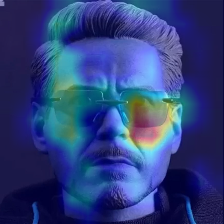

Heatmap for penultimate layer: 


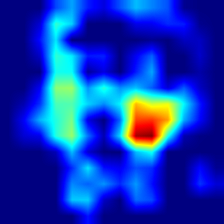

In [24]:
res, heatmap = gradOut(rdj, outs[0], last_second_conv_layer, kernels_last2)
print("Output of penultimate layer: ")
cv2_imshow(res)

print("Heatmap for penultimate layer: ")
cv2_imshow(heatmap)

### GradCam output for last 3rd layer

Output of last 3rd layer: 


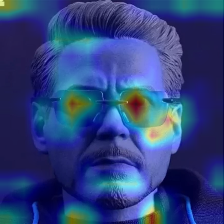

Heatmap for last 3rd layer: 


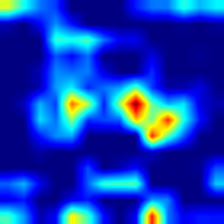

In [26]:
res1, heatmap1 = gradOut(rdj, outs[0], last_third_conv_layer, kernels_last3)

print("Output of last 3rd layer: ")
cv2_imshow(res1)

print("Heatmap for last 3rd layer: ")
cv2_imshow(heatmap1)

### Heatmap Thresholding

The white region in the image represents the area where network think the sunglasses are present

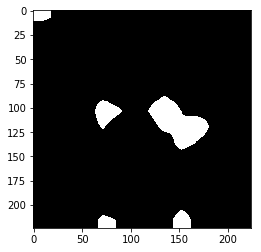

In [27]:
from matplotlib import pyplot as plt
# print(heatmap1.shape[:])

# Represent heatmap in RGB colorspace (This is for plotting since matplotlib and opencv uses different colorspace)
heatmap1 = cv2.cvtColor(heatmap1, cv2.COLOR_BGR2RGB)

# Split heatmap in r,g and b channel
r = heatmap1[:, :, 0]
g = heatmap1[:, :, 1]
b = heatmap1[:, :, 2]

# Set min and max pixel values for thresholding  
thresh = (100, 255)

# Take red channel since it represents where the network is focusing
binary_r = np.zeros_like(r)
binary_r[(r > thresh[0]) & (r <= thresh[1])] = 1

# Plot the thresholded result 
plt.imshow(binary_r, cmap='gray')
plt.show()

---

# Part 2 - Receptive Field

![alt text](Data/part2.jpg)

![alt text](https://i0.wp.com/syncedreview.com/wp-content/uploads/2017/05/32.png?resize=372%2C171&ssl=1)


| k | p | s |Input Image | Output Image | Jin | Jout | Receptive Field | 
| ---| --| -- | --------------------| ---------------------- | ---- | ------- | ------------------------- |
| 3 | 1 | 1 | 128              |      128              | 1  |      1   |             3               |
| 3 | 0 | 2 | 128              |        64              |  1  |      2  |             5              |
| 3 | 1 |  1|    64             |         64             |  2  |   2     |               9              |   
| 3 | 0 |  2|    64             |         32             |  2  |   4     |               13              |   
| 3 | 1 |  1|    32             |         32             |  4  |   4     |               21              |   
| 3 | 0 |  2|    32             |         16             |  4  |   8     |               29              |   
| 3 | 1 |  1|    16             |         16             |  8  |   8     |               45              |   


  - Input and output image size is given with the output receptive field of the layer
  - If the output dimension is half of the input dimension, then usually we consider that MaxPooling layer is used (i.e. k=2, p=0, s=2) but this won't satisfy the receptive field equation.
  - Using receptive field formula, we can findout the kernel size (**k**)
  - Using the receptive field equation, we can calculate **k=3**
  - If kernel size is 3 and input channel dimension is equal to output channel dimension implies a **padding of 1**
  - If kernel size is 3 and ouput channel dimension is half of the input channel dimension implies a **stride of 2**
  - Calculations for above 7 layers are shown in the table
  
For Layer 7:


- Since, input and output channel dimension are same, padding=1 and stride=1 for kernel size = 3
- Receptive Field calculation,  
r_out = 29 + (3-1)`*`(8)  
r_out = 29 +  16  
r_out = 45
